In [3]:
%matplotlib inline
import rebound as r
r.reset()
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
r.status()
from IPython.html.widgets import interact, interactive
from IPython.display import display

---------------------------------
Rebound version:     	1.1.0
Build on:            	Jun 24 2015 10:13:57
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


## Simulated data:

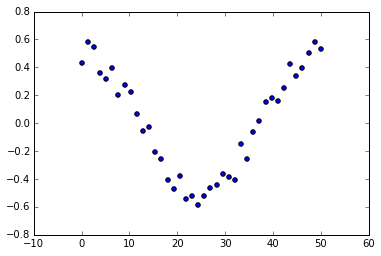

In [4]:
data_N = 40
data_t = np.linspace(0.,50.,data_N)+0.0005*np.random.rand(data_N)
data_rv = 0.500883379885605*(np.sin(2.*np.pi*data_t/50.+np.pi/2.)+0.4*(np.random.rand(data_N)-0.5))
plt.scatter(data_t, data_rv);

## Setting up simulations

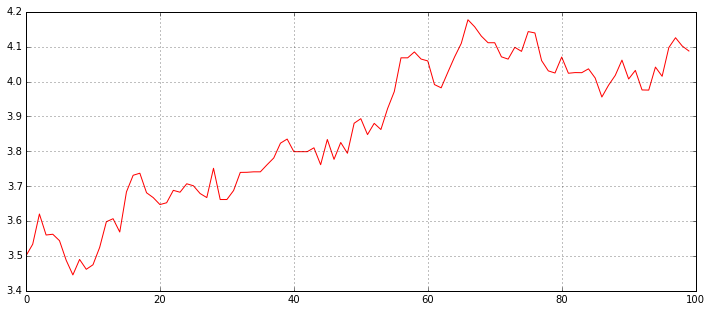

In [68]:
numvar = 4
N = 2
def varid2(l,k):
    if k>l:
        raise Exception("error")
    if l>=numvar:
        raise Exception("error")
    var = l*(l+1)/2+k
    return var*N+1+N+N*numvar
def varid1(l):
    if l>=numvar:
        raise Exception("error")
    return N*l+1+N
    
def simulation(cart):
    r.reset()
    r.N_megnopp = numvar 
    r.add(m=1.)
    op = r.Particle(a=cart[1],e=(np.tanh(cart[0])+1.)/2.,anom=cart[2],omega=cart[3])
    r.add(op)
    N = r.N
    r.init_megno(0.)
    ps = r.particles
    
    
    delta = 1e-4
    # First order
    for l in range(numvar):
        cart2 = cart.copy()
        cart2[l] += delta/2.
        mp = r.Particle(primary=ps[0],a=cart2[1],e=(np.tanh(cart2[0])+1.)/2.,anom=cart2[2],omega=cart2[3])
        cart2 = cart.copy()
        cart2[l] -= delta/2.
        mm = r.Particle(primary=ps[0],a=cart2[1],e=(np.tanh(cart2[0])+1.)/2.,anom=cart2[2],omega=cart2[3])

        vari = varid1(l)
        ps[vari].x  = (mp.x  - mm.x  )
        ps[vari].y  = (mp.y  - mm.y  )
        ps[vari].z  = (mp.z  - mm.z  )
        ps[vari].vx = (mp.vx - mm.vx )
        ps[vari].vy = (mp.vy - mm.vy )
        ps[vari].vz = (mp.vz - mm.vz )
        
    # Second order
    for l in range(numvar):
        for k in range(l+1):
            fac = 2.
            cart2 = cart.copy()
            cart2[l] += delta/fac
            cart2[k] += delta/fac
            mpp = r.Particle(primary=ps[0],a=cart2[1],e=(np.tanh(cart2[0])+1.)/2.,anom=cart2[2],omega=cart2[3])
            cart2 = cart.copy()
            cart2[l] += delta/fac
            cart2[k] -= delta/fac
            mpm = r.Particle(primary=ps[0],a=cart2[1],e=(np.tanh(cart2[0])+1.)/2.,anom=cart2[2],omega=cart2[3])
            cart2 = cart.copy()
            cart2[l] -= delta/fac
            cart2[k] += delta/fac
            mmp = r.Particle(primary=ps[0],a=cart2[1],e=(np.tanh(cart2[0])+1.)/2.,anom=cart2[2],omega=cart2[3])
            cart2 = cart.copy()
            cart2[l] -= delta/fac
            cart2[k] -= delta/fac
            mmm = r.Particle(primary=ps[0],a=cart2[1],e=(np.tanh(cart2[0])+1.)/2.,anom=cart2[2],omega=cart2[3])
            
            vari2 = varid2(l,k)
            ps[vari2].x  = mpp.x  - mpm.x  - mmp.x  + mmm.x
            ps[vari2].y  = mpp.y  - mpm.y  - mmp.y  + mmm.y 
            ps[vari2].z  = mpp.z  - mpm.z  - mmp.z  + mmm.z 
            ps[vari2].vx = mpp.vx - mpm.vx - mmp.vx + mmm.vx
            ps[vari2].vy = mpp.vy - mpm.vy - mmp.vy + mmm.vy
            ps[vari2].vz = mpp.vz - mpm.vz - mmp.vz + mmm.vz
    
    
    ##################################################################
    # INTEGRATION
    logp    = 0.
    logp_d  = np.zeros(numvar)
    logp_d2 = np.zeros((numvar*(numvar+1)/2,2))
    for i,t in enumerate(data_t):
        r.integrate(t)
        dv = ps[1].vx-data_rv[i]
        logp  += -dv**2
        for k in range(numvar):
            vari1 = varid1(k)
            logp_d[k] += -2.*ps[vari1].vx/delta * dv
        _id = 0
        for l in range(numvar):
            for k in range(l+1):
                vari2 = varid2(l,k)
                vari1l = varid1(l)
                vari1k = varid1(k)
                logp_d2[_id][0] += -2.*(ps[vari1l].vx * ps[vari1k].vx)/(delta*delta)
                # Expectation value removes next line
                logp_d2[_id][1] += -2.*(ps[vari2].vx * dv)/(delta*delta)
                _id += 1
    
    logp_d2m = np.zeros((numvar,numvar))
    _id = 0
    for l in range(numvar):
        for k in range(l+1):
            fdd = logp_d2[_id][0] + logp_d2[_id][1]
            logp_d2m[l,k] = fdd
            logp_d2m[k,l] = fdd
            _id +=1
    
    return logp, logp_d, logp_d2m

a0 = np.array([-10.,3.5,0.,-np.pi/2.]) # initial parameters
a = a0.copy()

N_param = 4
N_steps = 100
epsilon = 0.5
errs = np.zeros(N_steps)

def softabs(hessian):
    alpha = 0.01
    lam, Q = np.linalg.eig(-hessian)
    lam_twig = lam*1./np.tanh(alpha*lam)
    H_twig = np.dot(Q,np.dot(np.diag(lam_twig),Q.T))    
    #print lam
    #print lam_twig
    return H_twig

first = 1
for i in range(N_steps):
    if first==1:
        first = 0
        logp, gradient, hessian = simulation(a)
        G     = softabs(hessian)
        Ginv  = np.linalg.inv(G)
        Gsqrt = np.linalg.inv(np.linalg.cholesky(G))    


    
    astar = a + epsilon**2 * np.dot(Ginv, gradient)/2. + epsilon * np.dot(Gsqrt, np.random.normal(0.,1.,N_param))
    #astar = a + epsilon * np.dot(Gsqrt, np.random.normal(0.,1.,N_param))

    
    logpstar, gradientstar, hessianstar = simulation(astar)
    Gstar     = softabs(hessianstar)
    Ginvstar  = np.linalg.inv(Gstar)
    Gsqrtstar = np.linalg.inv(np.linalg.cholesky(Gstar))

    
    cov = epsilon**2 * Ginv
    covstar = epsilon**2 * Ginvstar
    
    var     = stats.multivariate_normal(astar, cov=cov)
    varstar = stats.multivariate_normal(a, cov=covstar)
    
    q1 = var.pdf(a)
    q2 = varstar.pdf(astar)
    #print "%.8e  %.8e  %.8e" % (float(q1/q2), float(q1), float(q2))
   
    if min(1.,np.exp(logpstar-logp)*q2/q1) > np.random.uniform():
        a = astar
        logp = logpstar
        gradient = gradientstar
        hessian = hessianstar
        G = Gstar
        Ginv = Ginvstar
        Gsqrt = Gsqrtstar 
    
    
    #print a
    #print astar
    errs[i] = a[1]
    
fig1 = plt.figure(figsize=(12,5))
plt.plot(range(N_steps), errs, color="r");
plt.grid()
    
 